In [1]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl

from src.data_preparation import mdl_dataset_prep as dataset_prep

import src.utils.load_config as load_config
import src.data_preparation.load_data as load_data
import src.feature_extraction.pca as feature_pca
import src.visualization.visualize_pca as visualize_pca
# import src.visualization.visualize_error as visualize_error
from src.visualization import mdl_introspect

from src.data_preparation.blocking_time_series_split import BlockingTimeSeriesSplit 
from src.data_preparation import mdl_dataset_prep
from src.data_preparation import mdl_dataset
from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class
from src.utils import reload_config
from src.modelling import mdl_history

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

In [2]:
# Path to config file
file_config = '../config/data_proc_full.yaml'

In [3]:
conf = reload_config.Config(file_config, rootdir=rootdir, verbose=1)

Config file found: ../config/data_proc_full.yaml
PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated 'pca_dir': ../config/data_proc_full.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/rf
Folder created

Subfolder created: /nird/projects/nird/NS2993K/Leo/results/rf/ml/
Subfolder created: /nird/projects/nird/NS2993K/Leo/results/rf/figures/
Config file updated 'results_dir': ../config/data_proc_full.yaml
Config folders updated.
Config copied to: /nird/projects/nird/NS2993K/Leo/results/rf
Config file found: /nird/projects/nird/NS2993K/Leo/results/rf/data_proc_full.yaml
Default config file is now the copied following one:
/nird/projects/nird/NS2993K/Leo/results/rf/data_proc_full.yaml


----

## Loading whole dataset

In [4]:
from importlib import reload

In [5]:
reload(mdl_history);

In [6]:
reload(mdl_dataset);

In [7]:
reload(load_data);

In [8]:
reload(reload_config);

## # ---------------------------------------------------

In [9]:
ds = mdl_dataset.Dataset(conf, invert_t=True)


Initialisation dataset...
History updated: bias
History updated: noass
History updated: keras
Loading data...
Retrieve siconc
Retrieve sisnthick
Retrieve zos
Retrieve vxsi
Retrieve vysi
Loading forcing values...
Loading pca...
Apply land/ocean mask...
Retrieve PCs and EOFs
Size of the training set:    2400 days
Size of the validation set:     0 days
Size of the test set:         600 days


## # ----------------------------------------------------------------------------

## # ----------------------------------------------------------------------------

## A first simple model

In [10]:
from sklearn.model_selection import TimeSeriesSplit

from src.visualization import time_serie_split #  import PlotTimeSerieSplit

In [11]:
from importlib import reload

In [12]:
reload(time_serie_split)

<module 'src.visualization.time_serie_split' from '/cluster/home/leoede/tardis/tardis-ml/src/visualization/time_serie_split.py'>

In [13]:
nsplit = 4
max_test_size = int(ds.dataset['Xtrain'].shape[0]/(nsplit +1))


In [14]:
ts_cv = TimeSeriesSplit(
    n_splits=nsplit,
    gap=0,
    max_train_size=ds.ntrain,
   test_size=max_test_size,
)
# test_size = nval -> train dataset too small for the first split

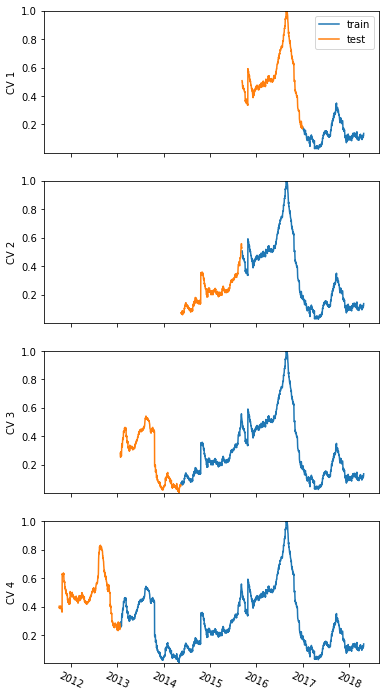

In [15]:
time_serie_split.PlotTimeSerieSplit(ts_cv, ds.dataset['Xtrain'], ds.dataset['chrono_train'], rootdir+ds.config.fig_dir, False, True)

In [17]:
ds.print_charac()


Dataset characteristics:
setup:                          default
TOPAZ4 non asssimiliated from:  freerun
Time reversed:                  True
Forcing/covar raw included:     True
Dataset used for:               train


----

In [ ]:
# bts_cv = BlockingTimeSeriesSplit(3)
# PlotTimeSerieSplit(bts_cv, Xtrain[:,:], chrono, rootdir+fig_dir, False, True)

----

### Initialize variables and model parameters

#### Input variables

In [34]:
npca = ds.dataset['y'].shape[1]

In [70]:
# additional parameters for the model

# cross validation
n_iter_bay = 5 # 100
bayesian_search = False
return_train_score = False
introspect = False

# input variables
# input_dico = ''  # default: all variables

# load input_dico, to set selection directly
# ! need same X !
# idir = '/nird/projects/nird/NS2993K/Leo/results/'

# idir = '/cluster/work/users/leoede/Leo/results/grdbst_Npred22_2F_rw21d_N4444_H1333_Hn0000_hice00_artc_220816-205402/ml/'
# ifile = 'input_dico_01.npy'

# idir = '/nird/projects/nird/NS2993K/Leo/results/grdbst_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc/ml/'
# ifile = 'input_dico.npy'
# dicoback = np.load(f'{idir}{ifile}', allow_pickle=True)
# input_dico = dicoback[None][0]

# load model
# model_to_load = ''


In [51]:
if ds.setup == 'no_bias':
    print('prediction non recursive because Xtp not in dataset')
    pred_type = 'simple'
else:
    if ds.config.nseq > 1:
        pred_type = 'sequence recursive'
    else:
        print('prediction recursive because Xtp in dataset')    
        pred_type = 'recursive'

In [37]:
# initilisation input_dico with new dataset class
input_dico = mdl_input_dico.InputDico()
input_dico.init_true(npca, ds.inputs)

In [39]:
# turn off Xe
# Xe_tf = ['Xe t+1 PC0', 'Xe t+1 PC1', 'Xe t+1 PC2', 'Xe t+1 PC3', 'Xe t+1 PC4', 'Xe t+1 PC5', 'Xe t+1 PC6', 'Xe t+1 PC7',
#         'Xe t+2 PC0', 'Xe t+2 PC1', 'Xe t+2 PC2', 'Xe t+2 PC3', 'Xe t+2 PC4', 'Xe t+2 PC5', 'Xe t+2 PC6', 'Xe t+2 PC7']
# input_dd.switch_to_false(Xe_tf)

In [40]:
# input_dd = mdl_input_dico.InputDico()
# input_dd.init_true(npca, inputs)

# input_dd.keep_only_best(ml_model)

In [41]:
# to put only Xe_tf to true
# input_dd.switch_to_false(inputs)
# input_dd.switch_to_false(Xe_tf)

In [42]:
# input_dd.dico['pc0'][:18];

In [43]:
# input_dd.dico.keys();

In [44]:
# input_dd.switch_to_true(folabels)

In [45]:
# input_dd.switch_to_true(hyplabels)

In [46]:
# input_dd.switch_to_false(['Xe t+1 PC0', 'la', 'Xe t+2 PC2', 'Xtp'])
# input_dd.switch_to_true(['airtmp t+3 PC0', 'airtmp t+6 PC0','airtmp t+9 PC0','airtmp t+12 PC0'])

----

In [47]:
from importlib import reload
reload(mdl_params);

----

#### GridSearch params / Model Params

In [42]:
param = mdl_params.Params(ds.config.ml_model, npca)

# param.get_search(booster='dart')
param.optimize(random_state=0, booster=None)  # 'dart')

In [43]:
param.param_opt.keys()

dict_keys(['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7'])

### Initialize model

In [44]:
from src.modelling import model_ridge
from src.modelling import model_rf
from src.modelling import model_grdbst
from src.modelling import model_xgboost
# from src.modelling import model_lstm


from src.modelling import model_utils

ml_classes = [model_ridge, model_rf, model_grdbst, model_xgboost]  # , model_lstm]  # etc
ml_classes_name = ['model_ridge', 'model_rf', 'model_grdbst', 'model_xgboost']  # , 'model_lstm']

In [51]:
# to load a specific model
# m1 = model_grdbst.ModelML(nfeat)
# m1.load('path/to/model/model_grdbst.joblib')  # or .save ?

In [46]:
ds.config.ml_model

'xgb'

In [48]:
# pick the corresponding machine learning model
ml_idx = [i for i, cl in enumerate(ml_classes_name) if ds.config.ml_model in cl][0]

In [54]:
# old way
# m1 = ml_classes[ml_idx].ModelML(npca, ntest, ntrain, inputs, rootdir, ml_dir, fig_dir)

init super model ML


In [64]:
reload(model_xgboost)

<module 'src.modelling.model_xgboost' from '/cluster/home/leoede/tardis/tardis-ml/src/modelling/model_xgboost.py'>

In [65]:
ds.config.rootdir

'/nird/projects/nird/NS2993K/'

In [66]:
m1 = ml_classes[ml_idx].ModelML(ds=ds, nsplit=nsplit, pred_type=pred_type)

init super model ML


In [68]:
m1.generate_model()

# ----------------------------------


In [362]:
# m1.dict_grid

In [363]:
# same parameters for all PCA
# m1.gridCV(param_grid, ts_cv, bayesian=bayesian_search, n_iter_bay=n_iter_bay, return_train_score=return_train_score)

In [71]:
# DIFFERENT PARAMETERS FOR EACH PCA
m1.improved_gridCV(param.param_opt, ts_cv, bayesian=bayesian_search, n_iter_bay=n_iter_bay, return_train_score=return_train_score)


In [56]:
# m1.input_dico = ''

In [74]:
m1.input_dico = input_dico.dico  # input_dico
m1.full_label = ds.inputs

----

In [77]:
m1.dico_param;

## FIRST FIT - LOOP FIT

In [ ]:
# m1.dict_grid['pc0'].best_estimator_['randomforestregressor'].n_estimators_
# il ny a pas de arg: .n_estimators_ in randomforest

In [78]:
m1.improved_fit(ds.dataset['Xtrain'], ds.dataset['ytrain'])

pc0 fit with 144 variables
['Xe t+1 PC0' 'Xe t+1 PC1' 'Xe t+1 PC2' 'Xe t+1 PC3' 'Xe t+1 PC4'
 'Xe t+1 PC5' 'Xe t+1 PC6' 'Xe t+1 PC7' 'Xe t+2 PC0' 'Xe t+2 PC1'
 'Xe t+2 PC2' 'Xe t+2 PC3' 'Xe t+2 PC4' 'Xe t+2 PC5' 'Xe t+2 PC6'
 'Xe t+2 PC7' 'Xe t+3 PC0' 'Xe t+3 PC1' 'Xe t+3 PC2' 'Xe t+3 PC3'
 'Xe t+3 PC4' 'Xe t+3 PC5' 'Xe t+3 PC6' 'Xe t+3 PC7' 'Xe t+8 PC0'
 'Xe t+8 PC1' 'Xe t+8 PC2' 'Xe t+8 PC3' 'Xe t+8 PC4' 'Xe t+8 PC5'
 'Xe t+8 PC6' 'Xe t+8 PC7' 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2'
 'SITf t+0 PC3' 'SITf t+0 PC4' 'SITf t+0 PC5' 'SITf t+0 PC6'
 'SITf t+0 PC7' 'SITf t+1 PC0' 'SITf t+1 PC1' 'SITf t+1 PC2'
 'SITf t+1 PC3' 'SITf t+1 PC4' 'SITf t+1 PC5' 'SITf t+1 PC6'
 'SITf t+1 PC7' 'SITf t+2 PC0' 'SITf t+2 PC1' 'SITf t+2 PC2'
 'SITf t+2 PC3' 'SITf t+2 PC4' 'SITf t+2 PC5' 'SITf t+2 PC6'
 'SITf t+2 PC7' 'SITf t+3 PC0' 'SITf t+3 PC1' 'SITf t+3 PC2'
 'SITf t+3 PC3' 'SITf t+3 PC4' 'SITf t+3 PC5' 'SITf t+3 PC6'
 'SITf t+3 PC7' 'SITf t+8 PC0' 'SITf t+8 PC1' 'SITf t+8 PC2'
 'SITf t+8 PC3' '

pc4 fit with 144 variables
['Xe t+1 PC0' 'Xe t+1 PC1' 'Xe t+1 PC2' 'Xe t+1 PC3' 'Xe t+1 PC4'
 'Xe t+1 PC5' 'Xe t+1 PC6' 'Xe t+1 PC7' 'Xe t+2 PC0' 'Xe t+2 PC1'
 'Xe t+2 PC2' 'Xe t+2 PC3' 'Xe t+2 PC4' 'Xe t+2 PC5' 'Xe t+2 PC6'
 'Xe t+2 PC7' 'Xe t+3 PC0' 'Xe t+3 PC1' 'Xe t+3 PC2' 'Xe t+3 PC3'
 'Xe t+3 PC4' 'Xe t+3 PC5' 'Xe t+3 PC6' 'Xe t+3 PC7' 'Xe t+8 PC0'
 'Xe t+8 PC1' 'Xe t+8 PC2' 'Xe t+8 PC3' 'Xe t+8 PC4' 'Xe t+8 PC5'
 'Xe t+8 PC6' 'Xe t+8 PC7' 'SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2'
 'SITf t+0 PC3' 'SITf t+0 PC4' 'SITf t+0 PC5' 'SITf t+0 PC6'
 'SITf t+0 PC7' 'SITf t+1 PC0' 'SITf t+1 PC1' 'SITf t+1 PC2'
 'SITf t+1 PC3' 'SITf t+1 PC4' 'SITf t+1 PC5' 'SITf t+1 PC6'
 'SITf t+1 PC7' 'SITf t+2 PC0' 'SITf t+2 PC1' 'SITf t+2 PC2'
 'SITf t+2 PC3' 'SITf t+2 PC4' 'SITf t+2 PC5' 'SITf t+2 PC6'
 'SITf t+2 PC7' 'SITf t+3 PC0' 'SITf t+3 PC1' 'SITf t+3 PC2'
 'SITf t+3 PC3' 'SITf t+3 PC4' 'SITf t+3 PC5' 'SITf t+3 PC6'
 'SITf t+3 PC7' 'SITf t+8 PC0' 'SITf t+8 PC1' 'SITf t+8 PC2'
 'SITf t+8 PC3' '

In [88]:
m1.pred_type = 'recursive'

In [89]:
m1.call_prediction(ds.dataset['X'], ds.dataset['y'])

todo: remove nseq and put in it in __init__(). do init by giving ds (dataset class)
> /cluster/home/leoede/tardis/tardis-ml/src/modelling/super_model_ml.py(41)call_prediction()
     39 
     40         print('todo: remove nseq and put in it in __init__(). do init by giving ds (dataset class)')
---> 41 
     42         if self.pred_type == 'simple':  # non recursive
     43             self.improved_predict(X, y)

ipdb> self.nH
*** AttributeError: 'ModelML' object has no attribute 'nH'
ipdb> self.nH=4
ipdb> c
todo: put that in a script in src/modelling/recursive_prediction.py


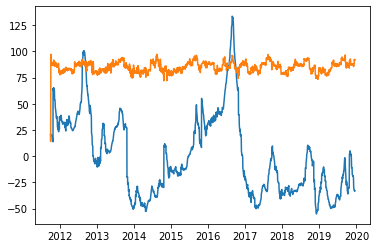

In [91]:
plt.plot(m1.chrono, m1.ytrue[:,0])
plt.plot(m1.chrono, m1.ypred[:,0])

In [ ]:
# m1.compute_score_staged_nest()
# mdl_introspect.plot_cvscore_nboosting_iter(m1, showfig=True)

In [53]:
if bayesian_search and m1.type == 'grdbst':
    mdl_introspect.plot_optimizer_full(m1, showfig=True)    

#### Evaluation training phase

In [92]:
m1.eval_grid_cv()



 pc0
CV results:
{'mean_fit_time': array([9.2976675]),
 'mean_score_time': array([0.22364455]),
 'mean_test_score': array([-0.17674356]),
 'param_xgbregressor__booster': masked_array(data=['dart'],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__colsample_bytree': masked_array(data=[0.2],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__learning_rate': masked_array(data=[0.934540199662753],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__max_depth': masked_array(data=[7],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__n_estimators': masked_array(data=[20],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__random_state': masked_array(data=[0],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregres

            dtype=object),
 'param_xgbregressor__random_state': masked_array(data=[0],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__rate_drop': masked_array(data=[0.9619218343220436],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__sample_type': masked_array(data=['uniform'],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__skip_drop': masked_array(data=[0.6],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__subsample': masked_array(data=[1],
             mask=[False],
       fill_value='?',
            dtype=object),
 'params': [{'xgbregressor__booster': 'dart',
             'xgbregressor__colsample_bytree': 0.2,
             'xgbregressor__learning_rate': 0.1,
             'xgbregressor__max_depth': 2,
             'xgbregressor__n_estimators': 20,
             'xgbregressor__random



 pc5
CV results:
{'mean_fit_time': array([4.00939071]),
 'mean_score_time': array([0.11923254]),
 'mean_test_score': array([0.74761149]),
 'param_xgbregressor__booster': masked_array(data=['dart'],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__colsample_bytree': masked_array(data=[0.5085646183074389],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__learning_rate': masked_array(data=[0.1],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__max_depth': masked_array(data=[8],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__n_estimators': masked_array(data=[20],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregressor__random_state': masked_array(data=[0],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_xgbregre

In [93]:
m1.cv_score()



 pc0
Mean Absolute Error:     19.066 +/- 16.785
R2:     -0.177 +/- 1.370
Root Mean Squared Error: 23.489 +/- 20.099


 pc1
Mean Absolute Error:     10.873 +/- 4.003
R2:     0.631 +/- 0.406
Root Mean Squared Error: 13.343 +/- 3.910


 pc2
Mean Absolute Error:     16.307 +/- 8.338
R2:     0.181 +/- 0.580
Root Mean Squared Error: 19.602 +/- 10.275


 pc3
Mean Absolute Error:     16.624 +/- 6.557
R2:     -0.247 +/- 0.926
Root Mean Squared Error: 21.505 +/- 9.146


 pc4
Mean Absolute Error:     10.008 +/- 5.510
R2:     0.462 +/- 0.473
Root Mean Squared Error: 13.056 +/- 6.330


 pc5
Mean Absolute Error:     7.019 +/- 5.757
R2:     0.748 +/- 0.229
Root Mean Squared Error: 10.176 +/- 9.758


 pc6
Mean Absolute Error:     8.577 +/- 4.742
R2:     0.527 +/- 0.271
Root Mean Squared Error: 11.073 +/- 5.461


 pc7
Mean Absolute Error:     3.115 +/- 2.144
R2:     0.749 +/- 0.368
Root Mean Squared Error: 4.393 +/- 3.247


### Visual evaluation of the prediction

In [95]:
from src.visualization import mdl_scatter_pred as msp
from src.visualization import mdl_non_recursive
from src.visualization import mdl_recursive
from src.visualization import mdl_recursive_sequence

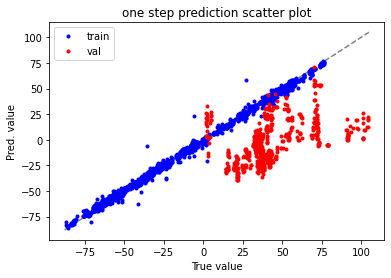

In [68]:
msp.draw_non_recursive(m1,0)

In [96]:
mdl_non_recursive.draw(m1, odir= m1.rootdir + m1.fig_dir, savefig=True)

AttributeError: 'ModelML' object has no attribute 'nfeat'

In [106]:
reload(mdl_recursive)

<module 'src.visualization.mdl_recursive' from '/cluster/home/leoede/tardis/tardis-ml/src/visualization/mdl_recursive.py'>

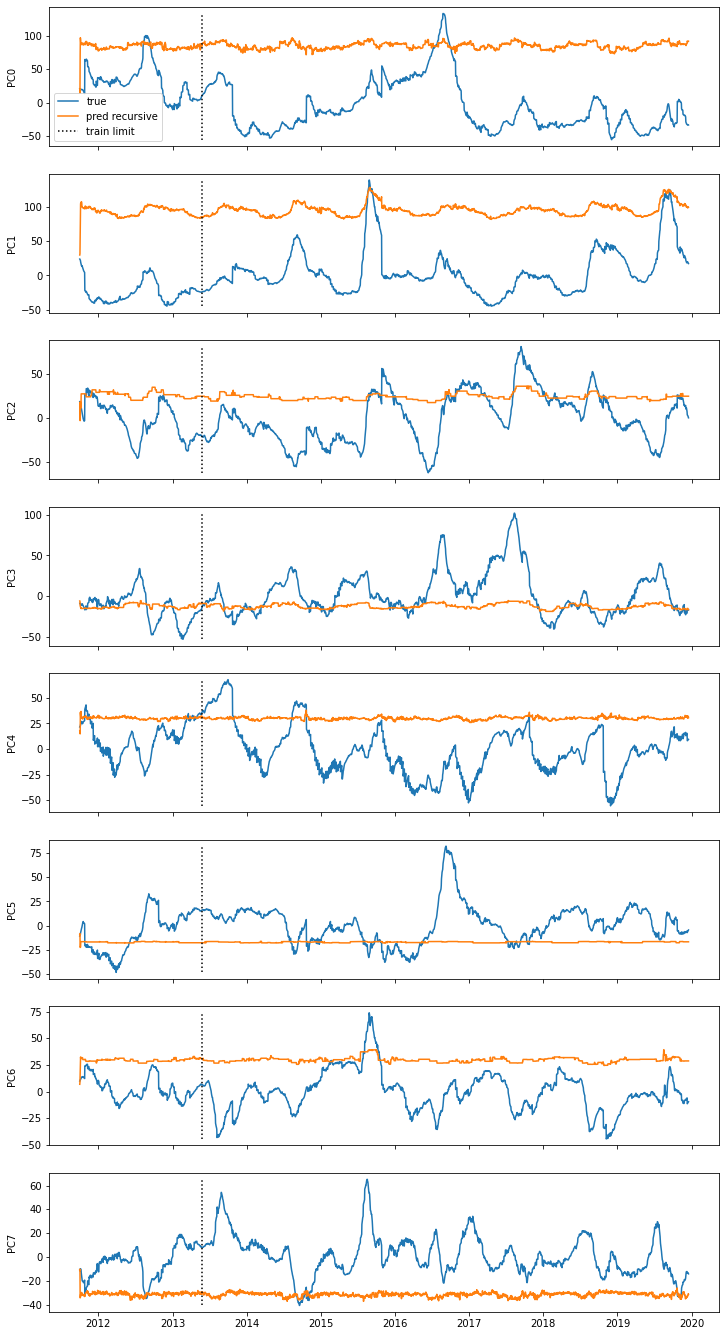

In [107]:
mdl_recursive.draw(m1, savefig=False, showfig=True, force=True)

-----

In [ ]:
from importlib import reload
reload(mdl_introspect);

In [ ]:
mdl_recursive_sequence.draw_seq(m1, savefig=False)

In [ ]:
mdl_recursive_sequence.draw(m1, savefig=True, odir= m1.rootdir + m1.fig_dir)

----

In [ ]:
# mrs.draw_seq(m1, savefig=True)
mdl_recursive_sequence.draw(m1, max_plot=8, savefig=True)

In [ ]:
reload(msp)

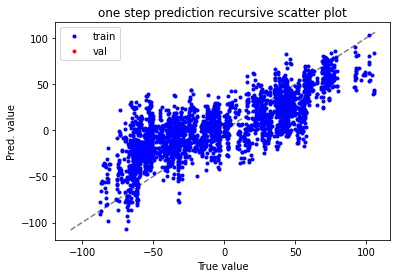

In [94]:
msp.draw_recursive(m1,0)

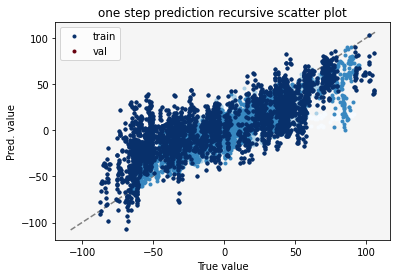

In [95]:
msp.draw_recursive_allfeat(m1, savefig=False)

------

### Evaluation variables importance

In [84]:
from src.visualization import visu_mdl_importance

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/importance_allPC_03.png


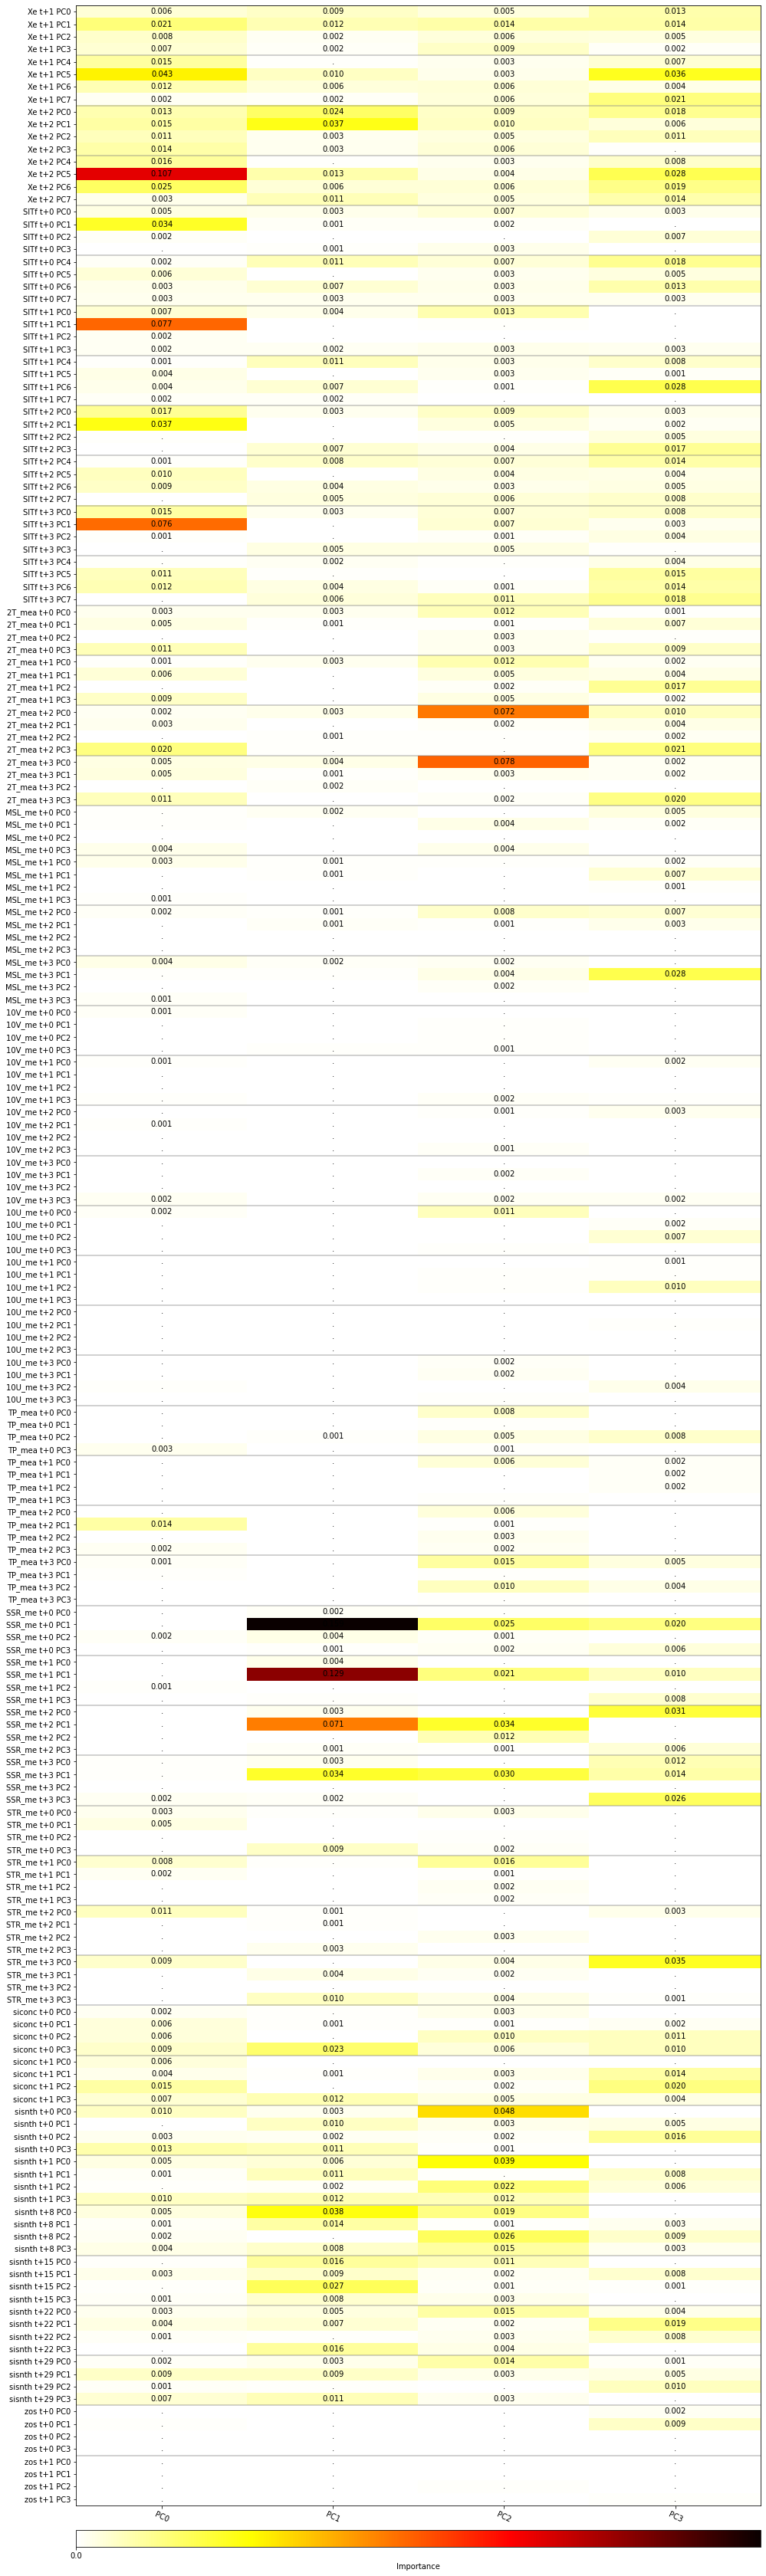

In [335]:
visu_mdl_importance.plot_importance_var_allpca(m1, savefig=True, showfig=True)

In [82]:
m1.dict_grid[f'pc{0}'].best_estimator_['xgbregressor'].feature_importances_

array([0.02958685, 0.0661945 , 0.0162646 , 0.00652253, 0.00470569,
       0.00960442, 0.01818333, 0.00335826, 0.01746339, 0.01650731,
       0.00168275, 0.00563468, 0.00264754, 0.0026184 , 0.03463104,
       0.00669349, 0.06816283, 0.01003367, 0.0035839 , 0.01671678,
       0.00662908, 0.00481729, 0.01747352, 0.00969011, 0.01208014,
       0.03820848, 0.00328671, 0.01991012, 0.01371318, 0.0052789 ,
       0.0024292 , 0.02994251, 0.        , 0.01368974, 0.00089798,
       0.        , 0.        , 0.        , 0.00379863, 0.00485421,
       0.        , 0.00285844, 0.00754908, 0.00406577, 0.00615687,
       0.00518282, 0.00210703, 0.        , 0.        , 0.00199177,
       0.        , 0.        , 0.02334722, 0.00540448, 0.00368825,
       0.007878  , 0.        , 0.        , 0.00468291, 0.00750433,
       0.00309367, 0.        , 0.00454864, 0.00418515, 0.        ,
       0.        , 0.0035671 , 0.00254068, 0.00251297, 0.00219688,
       0.00803479, 0.00668968, 0.        , 0.00282596, 0.00358

In [ ]:
# most importantes features
# i_pca = 0

# CASSE !!!!!!!!!!!!!!!!!!!! 

print('from GrdBstRegressor')
for Nf in range(4):
#     index = np.argsort(m1.dict_grid[f'pc{Nf}'].best_estimator_['gradientboostingregressor'].feature_importances_)
    index = np.argsort(m1.dict_grid[f'pc{Nf}'].best_estimator_['xgbregressor'].feature_importances_)
    
    most = 10
    name_most = np.array(m1.full_label)[index][::-1][:most]
#     print(name_most)
#     imp_most = m1.dict_grid[f'pc{Nf}'].best_estimator_['gradientboostingregressor'].feature_importances_[index][::-1][:most]
    imp_most = m1.dict_grid[f'pc{Nf}'].best_estimator_['xgbregressor'].feature_importances_[index][::-1][:most]
    
    print(f'\n10 most important variables, PC{Nf}:')
    for name, imp in zip(name_most, imp_most):
        print(f'{name:<15}', '   :   ', imp)



#### Compute permutation importance

In [ ]:
# put 0 instead of nan for permutation test
yrr = m1.yrec.copy()
yrr[np.where(np.isnan(m1.yrec))] = 0

m1.yrec = yrr

In [88]:
# permutation test
m1.compute_permutation_imp(redo=True)

! Random State = 0


In [ ]:
# permutation test on TRAIN Period
m1.compute_permutation_imp_train()

 -----

### check one tree

 -----

### Visu importance permu test

In [90]:
from src.visualization import mdl_permu_test

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/PermuImp_testset_xgb_PC0.png


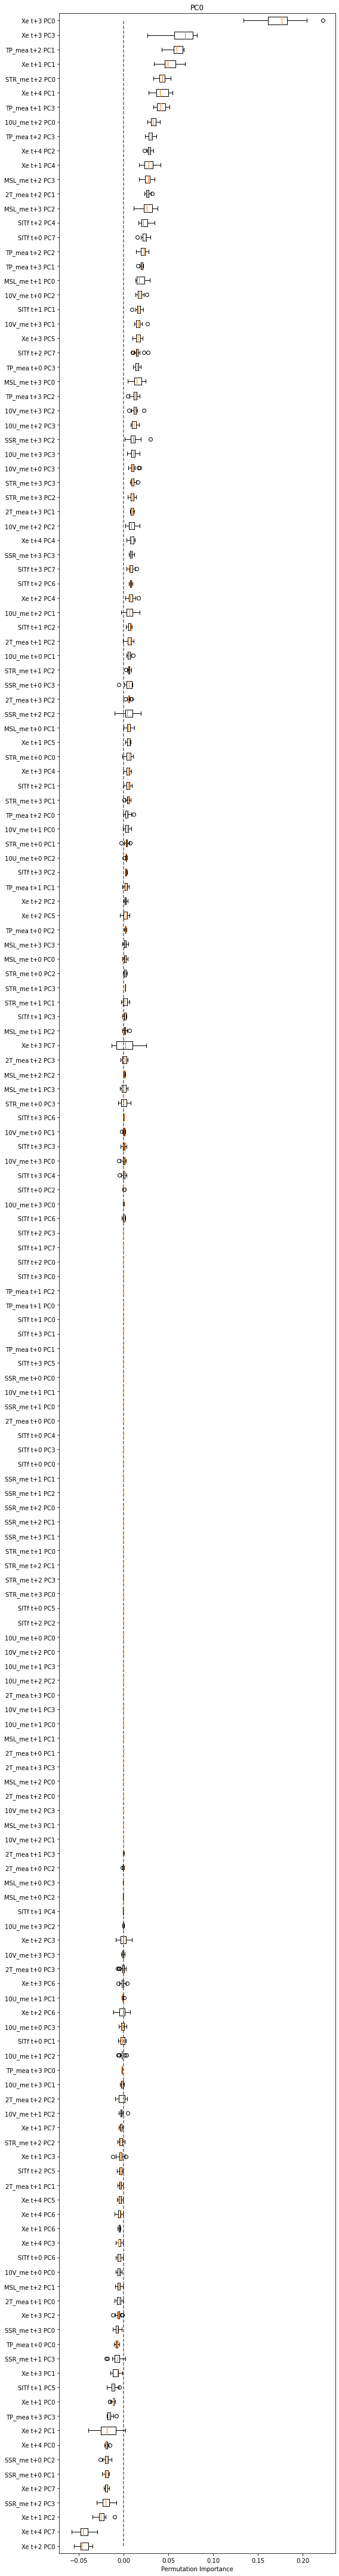

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/PermuImp_testset_xgb_PC1.png


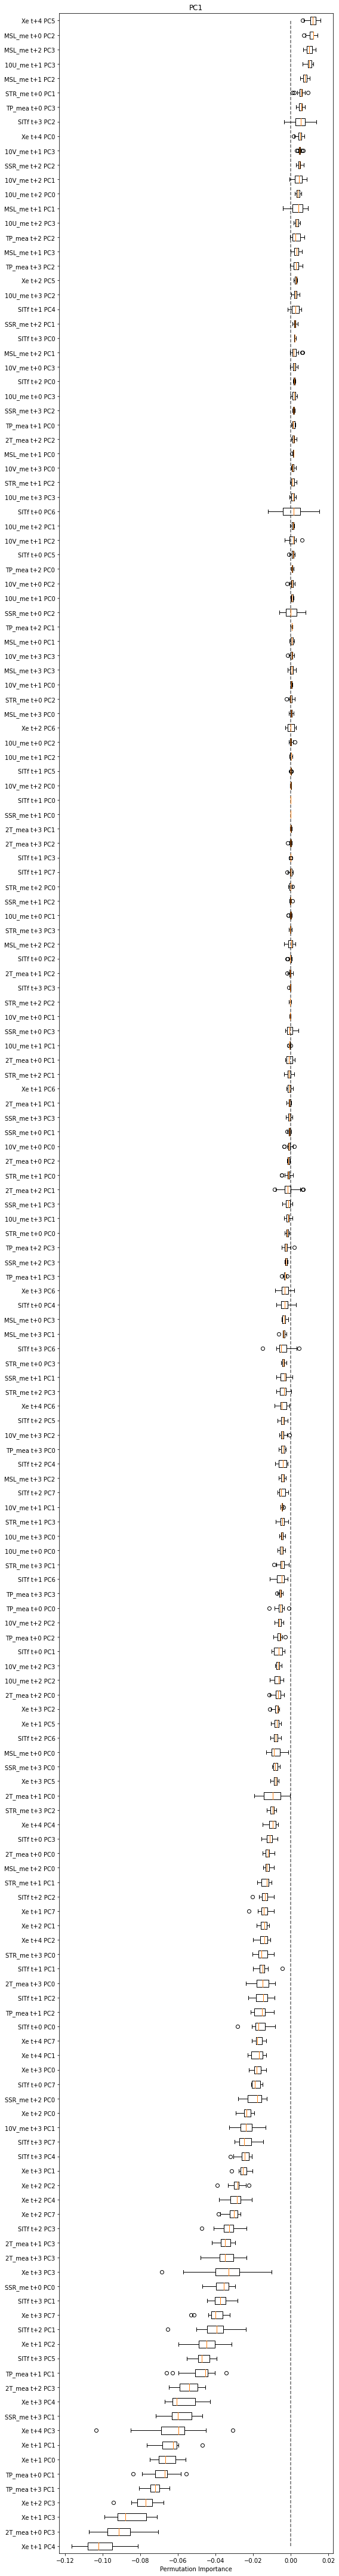

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/PermuImp_testset_xgb_PC2.png


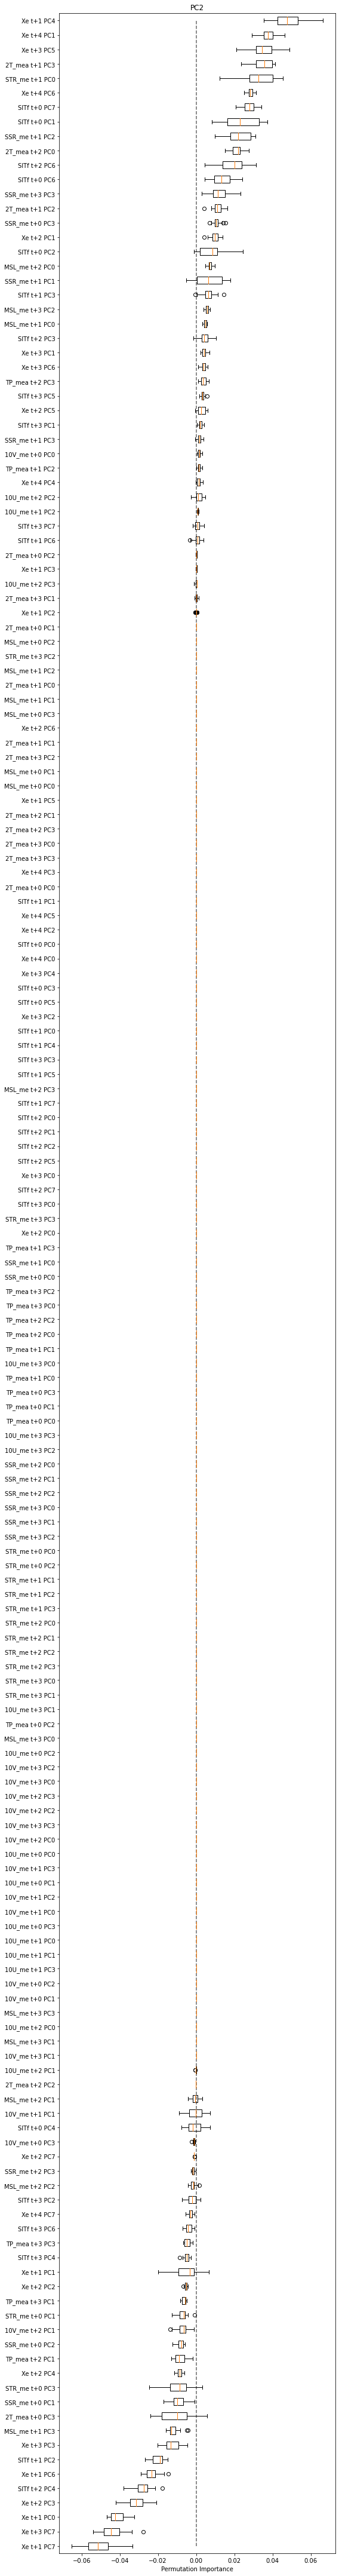

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/figures/PermuImp_testset_xgb_PC3.png


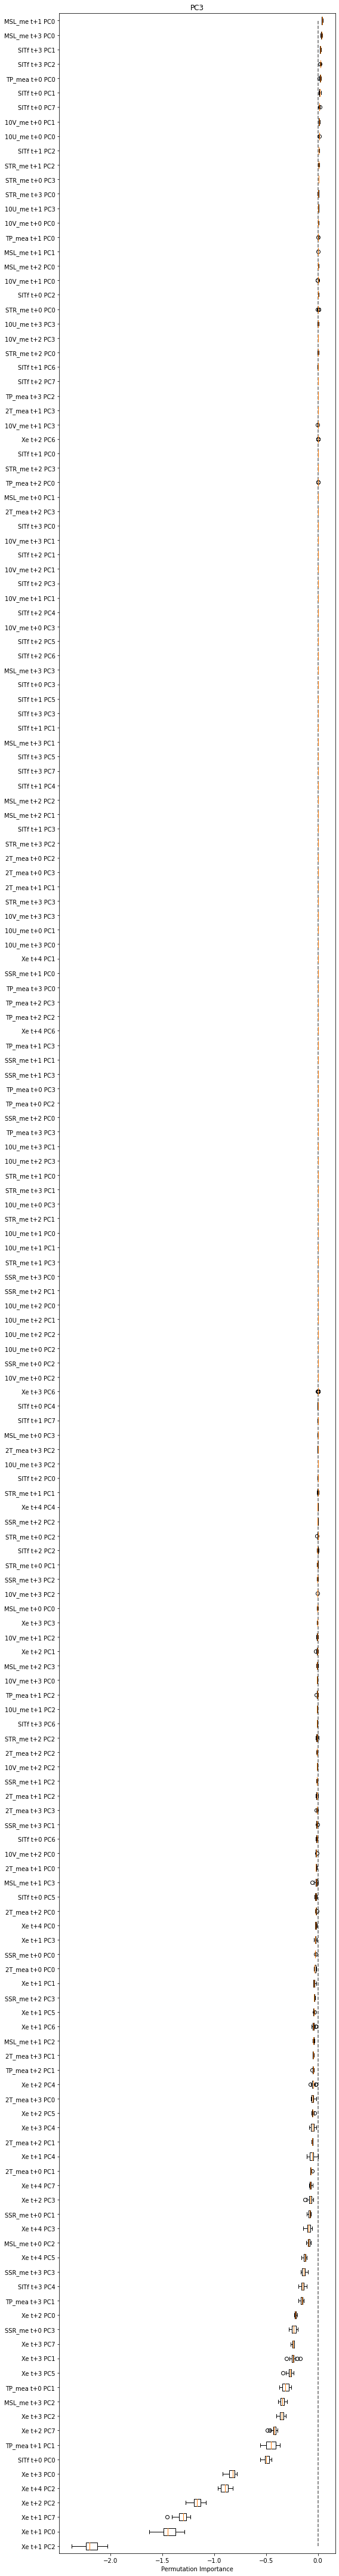

In [91]:
for i in range(4):
    mdl_permu_test.draw_permu_1pc(m1, i_pca=i, savefig=True, showfig=True)

In [ ]:
for i in range(4):
    mdl_permu_test.draw_permu_1pc(m1, i_pca=i, train=True, savefig=True, showfig=True)

### On garde seulement variables avec importance > 0

In [93]:
# on fit 1 algo par PCA car input differentes
m1.keep_var_imp(threshold=0.00, most_imp=.5)

Keep var important


TypeError: string indices must be integers

In [ ]:
m1.keep_best_param()

In [ ]:
# keep best params for next iteration

In [ ]:
# save input_dico
# in keep_var_imp()

In [ ]:
# input_dico shall be the same size forever
# tokeep (indexes) must keep the same size

# if var in false at iteration 1: 
# put it false at iteration 2, and importance = np.nan

In [ ]:
print(m1.input_dico);

 -----

 -----

### Save best estimator ML for later use

In [87]:
m1.save_best_est()

# save input_dico as well

ML model saved as:
/nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/ml/xgb_param_todo.save


In [379]:
ntrain, ntest

(2336, 584)

In [377]:
m1.save_ypred()

Yrec (prediction recursive) saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw15d_N8844_H1333_Hn0000_sithick_artc_221003-160103/ml/yrec_01.npy


### Reconstruct values 

-----